In [14]:
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath('..'))
from utils.process import drop_all_na_cols, fillna_with_zero, drop_zero_var_cols

df_labeled_train = pd.read_csv('../data/input/train_labeled.csv', index_col=0)
df_unlabeled_train = pd.read_csv('../data/input/train_unlabeled.csv', index_col=0)
df_test = pd.read_csv('../data/input/test.csv', index_col=0)

pipeline = [drop_all_na_cols, drop_zero_var_cols, fillna_with_zero]

for func in pipeline:
    df_labeled_train = func(df_labeled_train)

df_unlabeled_train = df_unlabeled_train[df_labeled_train.columns]
df_unlabeled_train = fillna_with_zero(df_unlabeled_train)
df_unlabeled_train['labels'] = -1

df_test = df_test[df_labeled_train.columns]
df_test = fillna_with_zero(df_test)
df_test['labels'] = -2

concatanated_df = pd.concat([df_labeled_train, df_unlabeled_train], axis=0)
y_labeled_train = df_labeled_train['labels'].values
print(concatanated_df.shape)

(2755, 1357)


In [15]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(
    sampling_strategy={5: 800},
    random_state=42, 
    k_neighbors=4)

X = df_labeled_train.drop('labels', axis=1)
y = df_labeled_train['labels']
X_res, y_res = sm.fit_resample(X, y)

X_res['labels'] = y_res
X_res['labels'].value_counts().T

5    800
0    300
3    300
2    300
1    300
4    300
Name: labels, dtype: int64

In [16]:
from pycaret.classification import ClassificationExperiment

s = ClassificationExperiment()
s.setup(
    X_res,
    target='labels',
    n_jobs=-1,
)

model_list = [s.create_model(model) 
              for model 
              in ['lightgbm', 'xgboost', 'rf', 'et']]
tuned_model_list = [s.tune_model(model, optimize='f1') for model in model_list]
blender = s.blend_models(tuned_model_list)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, c

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will b

In [19]:
df_test = pd.read_csv('../data/input/test.csv', index_col=0)
df_test = df_test[X_res.columns]
df_test = fillna_with_zero(df_test)
df_test.drop('labels', axis=1, inplace=True)

df_pred = s.predict_model(blender, data=df_test)['prediction_label']
print(df_pred.value_counts().T)
df_pred.to_csv('../data/output/003_smote.csv')

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
1    462
5    270
2    192
3    111
0    110
4    105
Name: prediction_label, dtype: int64


In [21]:
import umap
import matplotlib.pyplot as plt

mapper = umap.UMAP(
    random_state=0,
    n_neighbors=8,
    n_components=3,
    n_jobs=-1,
)

mapper.fit(concatanated_df.drop('labels', axis=1).values)
x_labeled = mapper.transform(df_labeled_train.drop('labels', axis=1).values)
x_unlabeled = mapper.transform(df_unlabeled_train.drop('labels', axis=1).values)
x_test = mapper.transform(df_test.values)

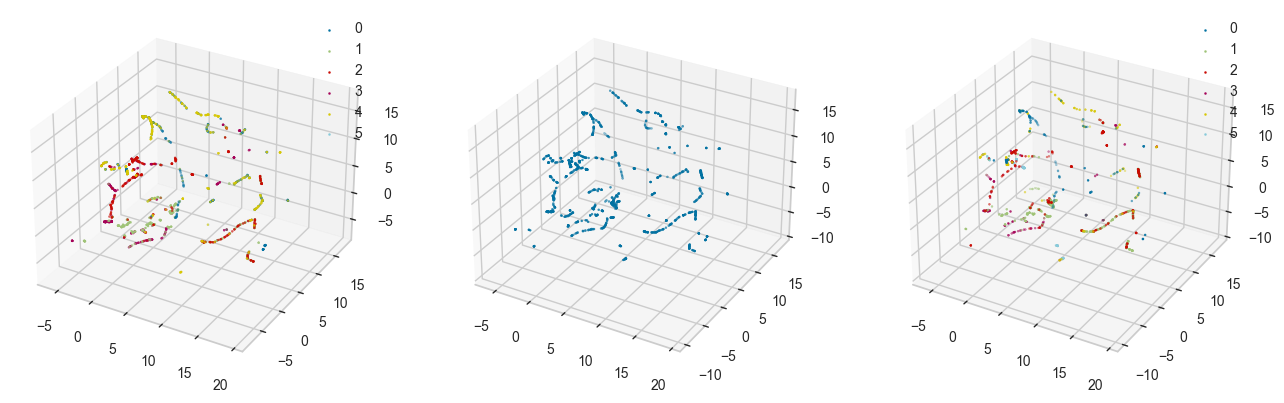

In [28]:
import numpy as np

fig, ax = plt.subplots(
    1, 3, figsize=(16, 12),subplot_kw=dict(projection="3d")
)
ax = ax.ravel()


for i in range(6):
    ax[0].scatter3D(
        x_labeled[y_labeled_train==i, 0],
        x_labeled[y_labeled_train==i, 1],
        x_labeled[y_labeled_train==i, 2],
        label=i,
        s=2,
    )

ax[1].scatter3D(
    x_unlabeled[:, 0],
    x_unlabeled[:, 1],
    x_unlabeled[:, 2],
    s=2,
)

for i in np.unique(df_pred.values):
    ax[2].scatter3D(
        x_test[df_pred.values==i, 0],
        x_test[df_pred.values==i, 1],
        x_test[df_pred.values==i, 2],
        label=i,
        s=2,
    )

ax[0].legend()
ax[2].legend()